### Importações das bibliotecas


In [136]:
import datetime
import numpy as np

# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# divisão em treino e teste, escalona e faz encoding de variáveis categóricas
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE

# métricas de performance de modelos
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# importando randomforestclassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna
import optuna.logging
# Definindo que apenas os avisos serão exibidos, para evitar spam nos outputs.
optuna.logging.set_verbosity(optuna.logging.WARNING)

### Importando a base de dados

In [2]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

In [167]:
# Treina o modelo, exibe precisão/recall, matriz de confusão, feature_importance
# retorna o modelo treinado, X_test, y_test, y_pred
def treinar_modelo(modelo, X: pd.DataFrame, y: pd.Series, metrics_report: bool=False, feature_importance_report: bool=False, threshold: bool=False) -> str:      
    # Criando o StratifiedKFold
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definindo um pipeline com StandardScaler e LogisticRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Definindo as métricas
    scoring = [
        'precision_weighted',
        'recall_weighted',
        'f1_weighted'
               ]

    # Calculando as métricas usando cross_validate
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        
    # treinando o modelo para obter a matriz de confusao
    train_index, test_index = next(skf.split(X,y))
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
 
    # pr_auc: Precision-Recall Area Under the Curve
    precisao, revocacao, limiares = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(revocacao, precisao)
    
    # caso deseje encontrar o melhor threshold:
    if threshold:
        plt.figure(figsize=(8, 6))
        plt.plot(limiares, precisao[:-1], label='Precision')
        plt.plot(limiares, revocacao[:-1], label='Recall')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Curva Precisão-Revocação-Threshold')
        plt.legend()
        plt.grid(True)
        plt.show();

        # Calcular o F1-score para cada threshold
        f1_scores = 2 * (precisao * revocacao) / (precisao + revocacao)

        # Encontrar o melhor threshold baseado no F1-score
        best_threshold = limiares[np.argmax(f1_scores)]

        print(f'Melhor Limiar (Threshold): {best_threshold:.2f}')
        print(f'Maior F1-score: {np.max(f1_scores):.2f}')
        
        y_pred = (y_pred_proba >= best_threshold).astype(int)
    else:
        y_pred = pipeline.predict(X_test)
            
    # exibe métricas e matriz de confusão
    if metrics_report:
            # Exibindo as métricas
            print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.2%}")
            print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.2%}")
            print(f"Média do F1 Score (Weighted): {scores['test_f1_weighted'].mean():.2%}")
            print(f'Precisão x Revocação, Área abaixo da Curva: ({pr_auc:.2%}) -> {pr_auc:.16f}')
        
            # plotando a matriz de confusão da cross_validate
            matriz_confusao = confusion_matrix(y_test, y_pred)
            sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Greens')

            # Configurações do gráfico
            plt.title('Matriz de confusão')
            plt.xlabel('Valor Predito')
            plt.ylabel('Valor Real')
            plt.show();    

    if feature_importance_report:
        # Acessando a importância das features
        if hasattr(pipeline.named_steps['modelo'], 'feature_importances_'):
            feature_importances = pipeline.named_steps['modelo'].feature_importances_
            importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
            importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
            print(importances_df)
            
    return pipeline, X_test, y_test, y_pred, y_pred_proba

In [4]:
# Relatório de Recursive Feature Elimination
def rfe_report(modelo, min_range: int=13, max_range: int=23):
    # Definir o StratifiedKFold com 2 folds
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=47)
    
    # Loop sobre os folds do StratifiedKFold para obter os splits estratificados
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # instanciamos o RFE
    selector = RFE(estimator=modelo)
    
    # Identificar as features selecionadas
    X_train_df = pd.DataFrame(X_train)
    
    # Instanciando variáveis controle:
    melhor_pr_auc = 0
    
    for qtd_features in range(min_range, max_range, 2):
        # definimos o número de features que devem permanecer
        selector.n_features_to_select = qtd_features

        # Executar RFE no fold de treino
        selector.fit(X_train, y_train)
        features_selecionadas = selector.support_

        # Filtrar as features selecionadas
        X_train_selecionado = X_train.loc[:, features_selecionadas]
        X_test_selecionado = X_test.loc[:, features_selecionadas]

        # Treinar o modelo com as features selecionadas
        modelo.fit(X_train_selecionado, y_train)

        # Prever probabilidades no fold de teste
        y_pred_proba = modelo.predict_proba(X_test_selecionado)[:, 1]

        # Calcular a curva Precision-Recall e AUC
        precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
        metrica_pr_auc = auc(revocacao, precisao)
        nome_features_selecionadas = [X_train_df.columns[i] for i, item in enumerate(features_selecionadas) if item]  
        
        # Comparar e atualizar o melhor resultado encontrado
        if metrica_pr_auc > melhor_pr_auc:         
            melhor_modelo_n_features = qtd_features
            melhores_features = nome_features_selecionadas.copy()
            melhor_pr_auc = metrica_pr_auc
            
            
        # exibe as informações do RFE atual
        print('----------------------------------------------')
        print(f'RFE {qtd_features} features - [INFO] Precision Recall AUC: ', metrica_pr_auc)
    # exibe as informações do melhor RFE
    print('----------------------------------------------')
    print(f'MELHOR "X_train" com {melhor_modelo_n_features} features:')
    print('[END] Precision Recall AUC: ', melhor_pr_auc)
    print("[END] Features selecionadas: ", melhores_features)
    
    # retorna o modelo com melhor rfe
    return melhores_features

# Modelagem
### Feature Engineering
Utilizaremos:
- EqualFrequencyDiscretiser: criando bins/intervalos com base em uma feature;
- LabelEncoder: transformando subcategorias em inteiros;
- Médias e desvios-padrão de features; e
- ratios: divisão de uma feature por outra

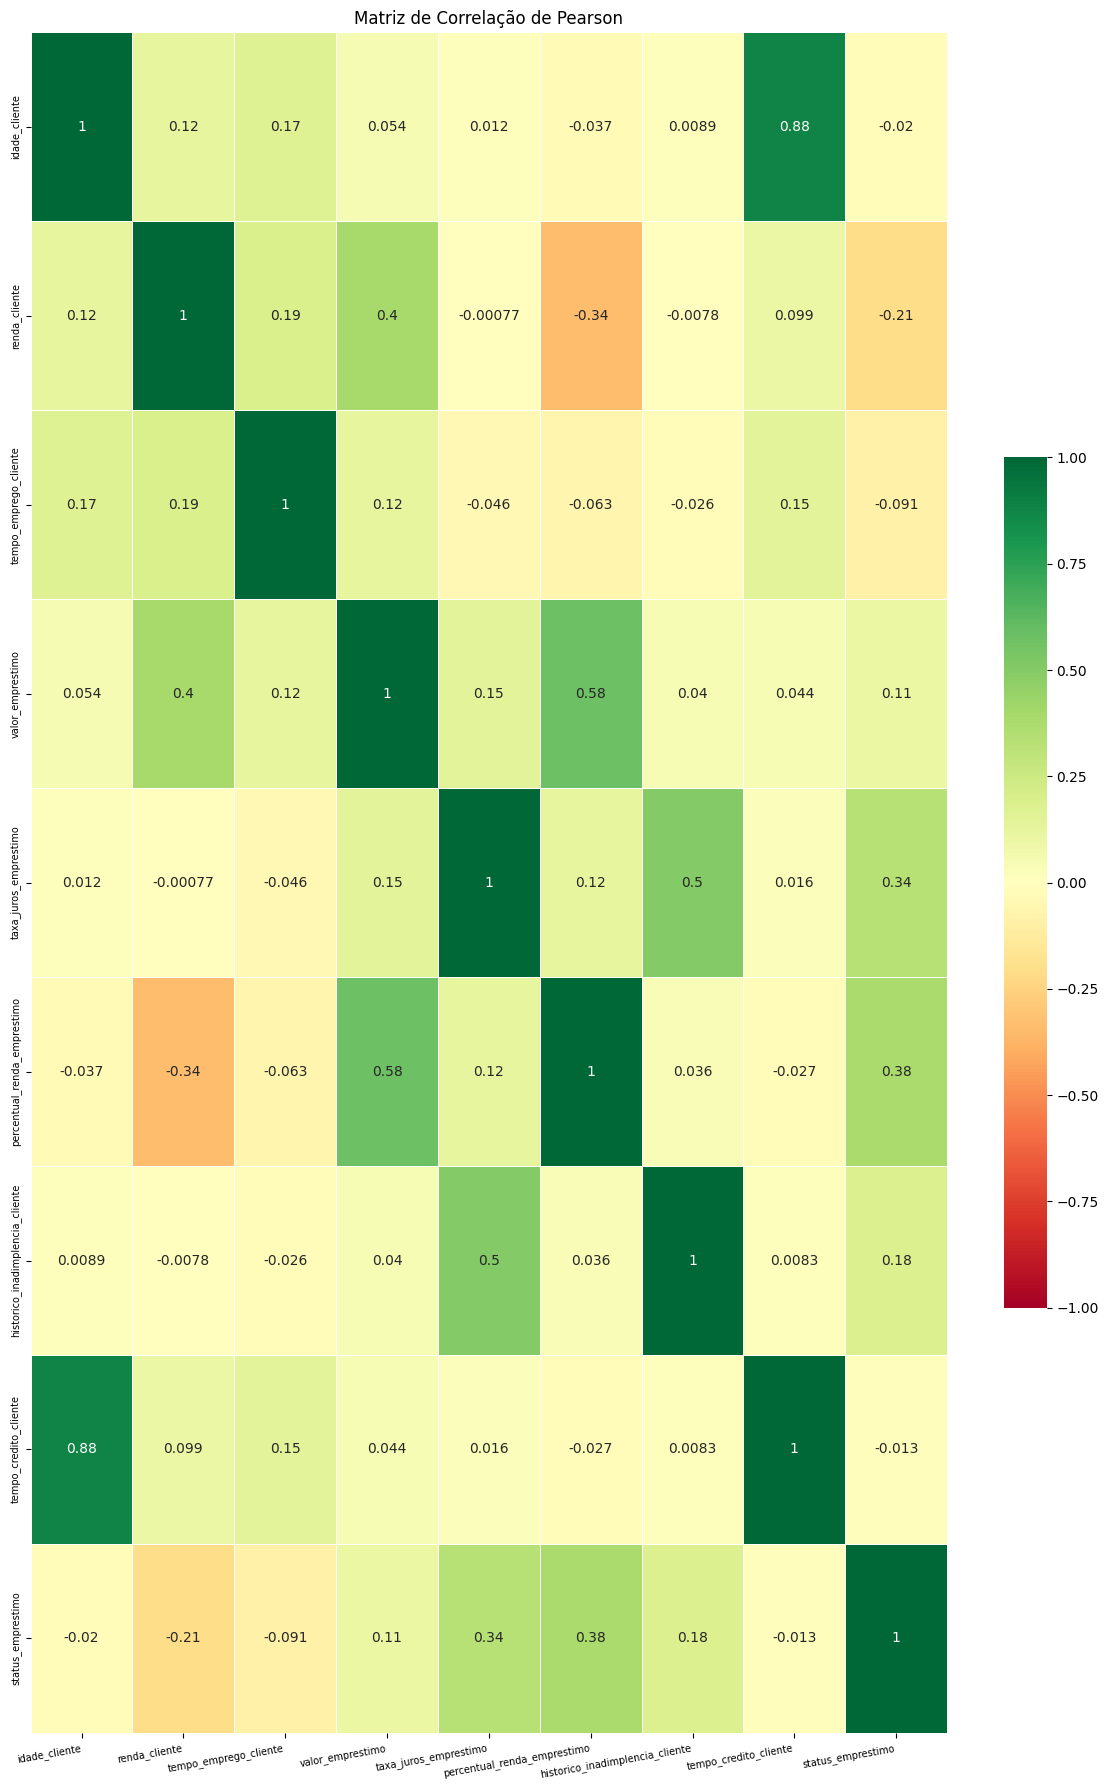

In [5]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz de correlação de Pearson
corr_matrix = df[numeric_cols].corr()

sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma forte correlação entre as variáveis ... inserir análise da correlação aqui. Com base nisso, criaremos as seguintes features:
 1. retorno_emprestimo = multiplicando (taxa_juros_emprestimo por valor_emprestimo) + valor_empréstimo;
 2. ratio_renda_emp = dividindo renda por emprestimo;
 3. ratio_emprego_credito = tempo_emprego_cliente dividido por tempo_credito_cliente, caso dividir por zero, resulta em zero;
 4. media_valemp_nota = média de valor_emprestimo para cada nota_emprestimo;
 5. media_valoremp_finalidade = média de valor_emprestimo para cada finalidade_emprestimo;
 6. std_valemp_residencia = desvio-padrão do valor_emprestimo por posse_residencia_cliente;
 7. media_renda_nota = média de renda_cliente para cada nota_emprestimo;
 8. media_renda_finalidade = média de renda_cliente para cada finalidade_emprestimo;
 9. std_renda_residencia = desvio-padrão do renda_cliente por posse_residencia_cliente;
10. ratio_emprego_renda = tempo_emprego_cliente dividido por renda_cliente
11. ratio_credito_renda = tempo_credito_cliente dividido por renda_cliente

In [6]:
# 1. 
df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)
# 2.
df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']
# 3. 
df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']
# 4.
df['media_valemp_nota'] = df.groupby(['nota_emprestimo'])['valor_emprestimo'].transform('mean')
# 5.
df['media_valemp_finalidade'] = df.groupby(['finalidade_emprestimo'])['valor_emprestimo'].transform('mean')
# 6.
df['std_valemp_residencia'] = df.groupby(['posse_residencia_cliente'])['valor_emprestimo'].transform('std')
# 7.
df['media_renda_nota'] = df.groupby(['nota_emprestimo'])['renda_cliente'].transform('mean')
# 8.
df['media_renda_finalidade'] = df.groupby(['finalidade_emprestimo'])['renda_cliente'].transform('mean')
# 9.
df['std_renda_residencia'] = df.groupby(['posse_residencia_cliente'])['renda_cliente'].transform('std')
# 10.
df['ratio_emprego_renda'] = df['tempo_emprego_cliente'] / df['renda_cliente']
# 11.
df['ratio_credito_renda'] = df['tempo_credito_cliente'] / df['renda_cliente']

In [7]:
df.dtypes

idade_cliente                        int16
renda_cliente                        int64
posse_residencia_cliente            object
tempo_emprego_cliente                int16
finalidade_emprestimo               object
nota_emprestimo                     object
valor_emprestimo                     int64
taxa_juros_emprestimo              float32
percentual_renda_emprestimo        float32
historico_inadimplencia_cliente      int16
tempo_credito_cliente                int16
status_emprestimo                    int16
retorno_emprestimo                 float64
ratio_renda_emp                    float64
ratio_emprego_credito              float64
media_valemp_nota                  float64
media_valemp_finalidade            float64
std_valemp_residencia              float64
media_renda_nota                   float64
media_renda_finalidade             float64
std_renda_residencia               float64
ratio_emprego_renda                float64
ratio_credito_renda                float64
dtype: obje

In [8]:
# visualizando o dataset após implementação
df.head(15)

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,Alugada,23,Pessoal,D,35000,16.020000,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
1,21,9600,Própria,5,Educação,B,1000,11.140000,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,Hipoteca,1,Médico,C,5500,12.870000,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
3,23,65500,Alugada,4,Médico,C,35000,15.230000,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,Alugada,8,Médico,C,35000,14.270000,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,Própria,2,Empreendimento,A,2500,7.140000,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,Alugada,8,Educação,B,35000,12.420000,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
7,24,78956,Alugada,5,Médico,B,35000,11.110000,0.44,0,...,2.255886,1.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000063,0.000051
8,24,83000,Alugada,8,Pessoal,A,35000,8.900000,0.42,0,...,2.371429,4.000000,8521.565413,9586.847630,5814.229899,65154.163508,65187.707459,31495.813457,0.000096,0.000024
9,21,10000,Própria,6,Empreendimento,D,1600,14.740000,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300


In [9]:
# instanciando o LabelEncoder
label_encoder_residencia = LabelEncoder()
label_encoder_finalidade_emp = LabelEncoder()
label_encoder_nota_emprestimo = LabelEncoder()

# encoding de features categóricas
df.posse_residencia_cliente = label_encoder_residencia.fit_transform(df.posse_residencia_cliente)
df.finalidade_emprestimo = label_encoder_finalidade_emp.fit_transform(df.finalidade_emprestimo)
df.nota_emprestimo = label_encoder_nota_emprestimo.fit_transform(df.nota_emprestimo)

### Avaliando a performance de modelos e respectivas Feature Importances

In [10]:
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

Instanciamos a variável target e as variáveis independentes.

In [11]:
# definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Como a Classe 1 é rara, o modelo Random Forest precisa que seja instanciado a proporção inversa de cada classe, definindo o peso de cada uma.
- Classe 0 -> Peso: 0.6406821745948772
- Classe 1  -> Peso: 2.2770552717138877

Média da Precisão (Weighted): 93.73%
Média da Revocação (Weighted): 93.41%
Precisão Média: 87.70%
Média do F1 Score (Weighted): 93.01%
Precisão x Revocação, Área abaixo da Curva: (89.07%) -> 0.8907022386515697


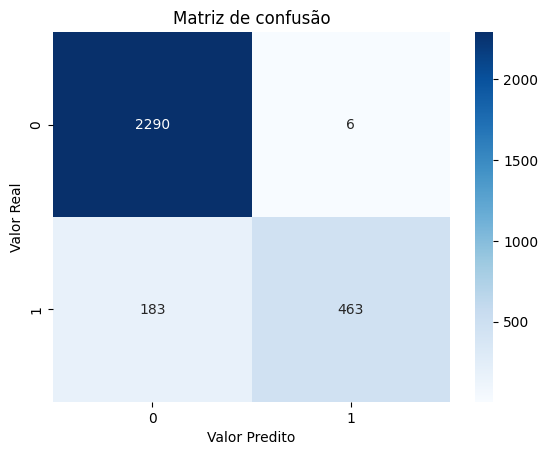

                            Feature  Importance
0                   ratio_renda_emp    0.113278
1       percentual_renda_emprestimo    0.108333
2                     renda_cliente    0.090277
3             taxa_juros_emprestimo    0.071852
4                   nota_emprestimo    0.066219
5                 media_valemp_nota    0.057607
6                retorno_emprestimo    0.053139
7               ratio_credito_renda    0.048131
8               ratio_emprego_renda    0.043472
9                  valor_emprestimo    0.036724
10            std_valemp_residencia    0.036481
11                    idade_cliente    0.031740
12            ratio_emprego_credito    0.031233
13            tempo_emprego_cliente    0.030708
14             std_renda_residencia    0.030476
15           media_renda_finalidade    0.028534
16          media_valemp_finalidade    0.026570
17            finalidade_emprestimo    0.024460
18         posse_residencia_cliente    0.023900
19            tempo_credito_cliente    0

In [12]:
randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)

rf_treinado, _, _, _, _  = treinar_modelo(randomforestclassifier, X, y, True, True)

Média da Precisão (Weighted): 93.86%
Média da Revocação (Weighted): 93.59%
Precisão Média: 89.75%
Média do F1 Score (Weighted): 93.23%
Precisão x Revocação, Área abaixo da Curva: (90.51%) -> 0.9050843326661133


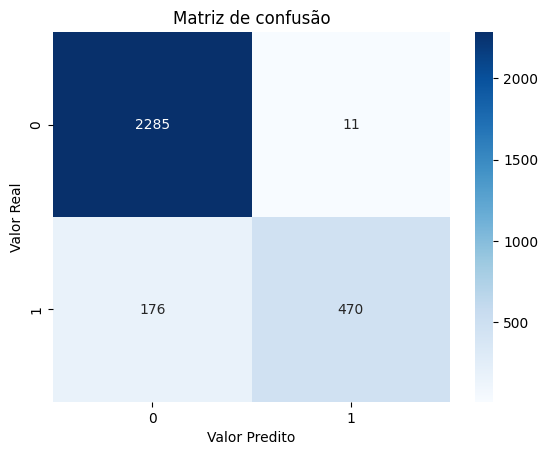

                            Feature  Importance
0             std_valemp_residencia    0.278073
1                   ratio_renda_emp    0.194169
2                   nota_emprestimo    0.174579
3          posse_residencia_cliente    0.048967
4             tempo_emprego_cliente    0.043699
5             finalidade_emprestimo    0.043159
6                     renda_cliente    0.039638
7           media_valemp_finalidade    0.038048
8            media_renda_finalidade    0.029182
9       percentual_renda_emprestimo    0.026054
10                    idade_cliente    0.017936
11            taxa_juros_emprestimo    0.015554
12            ratio_emprego_credito    0.006767
13               retorno_emprestimo    0.006633
14              ratio_emprego_renda    0.006528
15              ratio_credito_renda    0.006410
16                media_valemp_nota    0.006354
17  historico_inadimplencia_cliente    0.005235
18                 valor_emprestimo    0.004980
19            tempo_credito_cliente    0

In [13]:
xgbclassifier = XGBClassifier(n_estimators=30, random_state=47)

xgboost_treinado, _, _, _, _  = treinar_modelo(xgbclassifier, X, y, True, True)

Média da Precisão (Weighted): 92.01%
Média da Revocação (Weighted): 91.93%
Precisão Média: 85.60%
Média do F1 Score (Weighted): 91.46%
Precisão x Revocação, Área abaixo da Curva: (86.11%) -> 0.8611379739979680


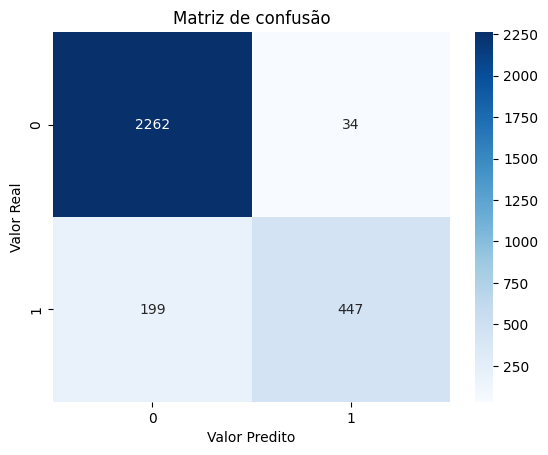

                            Feature  Importance
0                   ratio_renda_emp    0.338697
1                   nota_emprestimo    0.171340
2              std_renda_residencia    0.107614
3                 media_valemp_nota    0.103150
4                     renda_cliente    0.102327
5             std_valemp_residencia    0.058005
6             finalidade_emprestimo    0.025058
7          posse_residencia_cliente    0.023656
8             tempo_emprego_cliente    0.022319
9           media_valemp_finalidade    0.022150
10            taxa_juros_emprestimo    0.011539
11           media_renda_finalidade    0.008312
12      percentual_renda_emprestimo    0.004031
13                 media_renda_nota    0.001791
14              ratio_credito_renda    0.000012
15              ratio_emprego_renda    0.000000
16                    idade_cliente    0.000000
17            ratio_emprego_credito    0.000000
18            tempo_credito_cliente    0.000000
19  historico_inadimplencia_cliente    0

In [14]:
gradientboostingclassifier = GradientBoostingClassifier(n_estimators=30, random_state=47)

gradientboost_treinado, _, _, _, _  = treinar_modelo(gradientboostingclassifier, X, y, True, True)

### Análise dos modelos e respectivas Features Importances
Para evitar overfitting e capturar ruídos dos dados, preferimos verificar a importância das features em cada modelo e tratar as piores posteriormente. Os modelos foram treinados com 10 folds no StratifiedKFold (SKF) em razão do desbalanceamento de classes, situação em que o SKF lida bem na distribuição de folds em treino e teste estratificando-os.
- Random Forest Classifier:
    - Precisão: 0.937
    - Acurácia: 0.934
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - percentual_renda_emprestimo
        - renda_cliente
        - nota_emprestimo
        - taxa_juros_emprestimo
    - Nenhuma feature sem importância para o modelo, sendo EqualFrequencyDiscretiser 6 das com menor importância.
- XGBoost Classifier:
    - Precisão: 0.939
    - Acurácia: 0.936
    - Top 5 Feature Importance:
        - std_valemp_residencia
        - ratio_renda_emp
        - nota_emprestimo
        - posse_residencia_cliente
        - tempo_emprego_cliente
    - 7 features sem importância para o modelo, sendo 6 delas EqualFrequencyDiscretiser.
- Gradient Boosting Classifier:
    - Precisão: 0.920
    - Acurácia: 0.919
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - media_valemp_nota
        - std_valemp_residencia
        - nota_emprestimo
        - renda_cliente
    - 12 features sem importância para o modelo, sendo 5 delas EqualFrequencyDiscretiser.

 ### Feature Selection
- RFE (Recursive Feature Elimination)
    - Testamos manualmente a quantidade de features cuja métrica utilizada foi a área abaixo da curva entre precisão e revocação (pr_auc).

In [15]:
#randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)
features_RFE_randomforest = rfe_report(randomforestclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8691983969835009
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8728516388140086
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8755369624295806
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8769609630296833
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8796833135911417
----------------------------------------------
MELHOR "X_train" com 21 features:
[END] Precision Recall AUC:  0.8796833135911417
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'tempo_credito_cliente', 'retorno_emprestimo', 'ratio_renda_emp

No RandomForestClassifier obtemos o melhor resultado com 21 features e pr_auc de: 0.8774863465552638

In [75]:
rfe_report(randomforestclassifier, 20, 23)

----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8750787859513534
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8776129312863923
----------------------------------------------
MELHOR "X_train" com 22 features:
[END] Precision Recall AUC:  0.8776129312863923
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'historico_inadimplencia_cliente', 'tempo_credito_cliente', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_nota', 'media_renda_finalidade', 'std_renda_residencia', 'ratio_emprego_renda', 'ratio_credito_renda']


,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
3,23,65500,0,4,4,2,35000,15.23,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,0,8,4,2,35000,14.27,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,3,2,2,0,2500,7.14,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,0,8,1,1,35000,12.42,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
8,24,83000,0,8,5,0,35000,8.90,0.42,0,...,2.371429,4.000000,8521.565413,9586.847630,5814.229899,65154.163508,65187.707459,31495.813457,0.000096,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29406,52,52000,3,0,5,0,9600,8.49,0.18,0,...,5.416667,0.000000,8521.565413,9586.847630,6200.190887,65154.163508,65187.707459,41373.782824,0.000000,0.000423
29407,56,90000,1,0,5,0,7200,6.17,0.08,0,...,12.500000,0.000000,8521.565413,9586.847630,6770.406753,65154.163508,65187.707459,46037.084190,0.000000,0.000211
29408,52,65004,0,4,5,3,20000,15.58,0.31,1,...,3.250200,0.210526,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000062,0.000292
29410,57,53000,1,1,5,2,5800,13.16,0.11,0,...,9.137931,0.033333,9221.676127,9586.847630,6770.406753,62525.863089,65187.707459,46037.084190,0.000019,0.000566


Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no Random Forest, podemos confirmar que com 21 features a área abaixo da curva é maior.

In [16]:
features_RFE_xgboost = rfe_report(xgbclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8952305582918479
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8959121243804614
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8935843658858127
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8911982306089736
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8943905834787531
----------------------------------------------
MELHOR "X_train" com 15 features:
[END] Precision Recall AUC:  0.8959121243804614
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'ratio_renda_emp', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda

No XGBClassifier obtemos o melhor resultado com 15 features e pr_auc de: 0.8959121243804614

In [77]:
rfe_report(xgbclassifier, 14, 17)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8921034245373514
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8919291194519638
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8921034245373514
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'ratio_renda_emp', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'ratio_emprego_renda', 'ratio_credito_renda']


,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,ratio_renda_emp,media_valemp_finalidade,std_valemp_residencia,media_renda_finalidade,ratio_emprego_renda,ratio_credito_renda
3,23,65500,0,4,4,2,15.23,0.53,1.871429,9244.618566,5814.229899,59818.228309,0.000061,0.000031
4,24,54400,0,8,4,2,14.27,0.55,1.554286,9244.618566,5814.229899,59818.228309,0.000147,0.000074
5,21,9900,3,2,2,0,7.14,0.25,3.960000,9568.263066,6200.190887,65236.276083,0.000202,0.000202
6,26,77100,0,8,1,1,12.42,0.45,2.202857,9481.100478,5814.229899,63593.200957,0.000104,0.000039
8,24,83000,0,8,5,0,8.90,0.42,2.371429,9586.847630,5814.229899,65187.707459,0.000096,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29406,52,52000,3,0,5,0,8.49,0.18,5.416667,9586.847630,6200.190887,65187.707459,0.000000,0.000423
29407,56,90000,1,0,5,0,6.17,0.08,12.500000,9586.847630,6770.406753,65187.707459,0.000000,0.000211
29408,52,65004,0,4,5,3,15.58,0.31,3.250200,9586.847630,5814.229899,65187.707459,0.000062,0.000292
29410,57,53000,1,1,5,2,13.16,0.11,9.137931,9586.847630,6770.406753,65187.707459,0.000019,0.000566


Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no XGBoost, podemos confirmar que com 15 features a área abaixo da curva é maior.

In [15]:
rfe_report(gradientboostingclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8587315285833008
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8587160272358276
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8587160272358276
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.858718148516343
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.858718148516343
----------------------------------------------
MELHOR "X_train" com 13 features:
[END] Precision Recall AUC:  0.8587315285833008
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade'

No GradientBoostingClassifier obtemos o melhor resultado com 14 features e pr_auc de: 0.8587315285833008

In [17]:
features_RFE_gbc = rfe_report(gradientboostingclassifier, 14, 17)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8587347052392438
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8587181485163431
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8587347052392438
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'std_renda_residencia']


Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no XGBoost, podemos verificar que com 14 features a área abaixo da curva é maior.

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna


In [18]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # definir o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        criterion='entropy',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X[features_RFE_randomforest], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [19]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo:", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo: 4:53:14.598743
Melhores hiperparâmetros:  {'n_estimators': 263, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 0.8533967890879526}


In [20]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # definir o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X[features_RFE_xgboost], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [21]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no xgboost
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_xgboost = XGBClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  0:02:39.743783
Melhores hiperparâmetros:  {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.37010357027104934, 'gamma': 0.0840143993260119}


In [22]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # ['auto', 'sqrt', 'log2']
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X[features_RFE_gbc], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [23]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_gradient_boost = GradientBoostingClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classific

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Guilherme Bibiano\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_13852\2606512428.py", line 6, in <module>
    study.optimize(objective, n_trials=30)
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\study.py", line 451, in optimize
    _optimize(
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 62, in _optimize
    _optimize_sequential(
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 159, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 247, in _run_trial
    raise func_err
  File "

### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 93.84%
Média da Revocação (Weighted): 93.57%
Precisão Média: 89.83%
Média do F1 Score (Weighted): 93.20%
Precisão x Revocação, Área abaixo da Curva: (90.47%) -> 0.9046861526686355


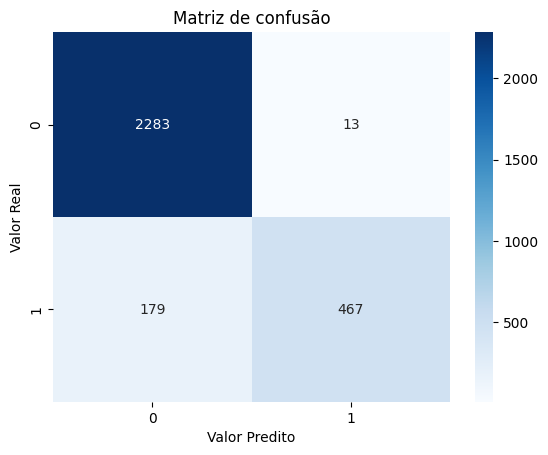

In [27]:
# treinando o random forest classifier
randomforestclassifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=254,
    max_depth=22,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=0.6469137671892833,
    class_weight=pesos, # peso das classes
    random_state=47
)

rf_treinado, _, _, _, _ = treinar_modelo(randomforestclassifier, X[features_RFE_randomforest], y, True)

Média da Precisão (Weighted): 93.66%
Média da Revocação (Weighted): 93.54%
Média do F1 Score (Weighted): 93.23%
Precisão x Revocação, Área abaixo da Curva: (91.82%) -> 0.9182335820011455


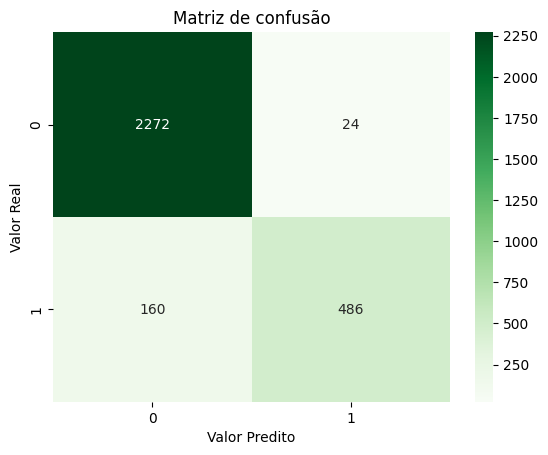

In [168]:
# Melhores hiperparâmetros:  {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.37010357027104934, 'gamma': 0.0840143993260119}
# treinando o xgboost classifier
xgbclassifier = XGBClassifier(
    n_estimators=242,
    max_depth=3,
    learning_rate=0.37010357027104934,
    gamma=0.0840143993260119,
    random_state=47
)

xgb_treinado, _, y_test, y_pred, _ = treinar_modelo(xgbclassifier, X[features_RFE_xgboost], y, True)

Média da Precisão (Weighted): 0.935
Média da Revocação (Weighted): 0.935


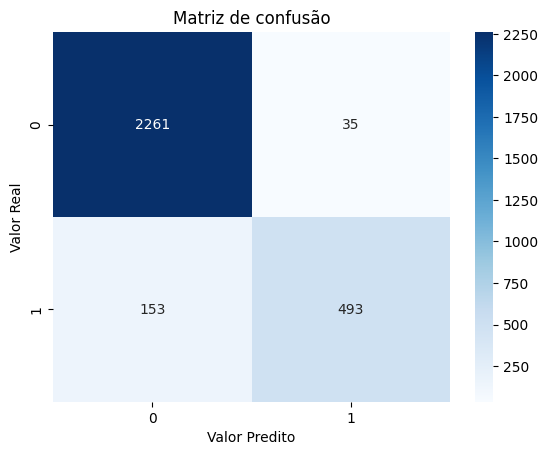

In [71]:
# treinando o gradient boosting classifier
gradientboostingclassifier = GradientBoostingClassifier(
    n_estimators=212,
    max_depth=13,
    learning_rate=0.5861968824622992,
    min_samples_split=18,
    min_samples_leaf=9,
    max_features=0.79471308745148,
    random_state=47
)

gbc_treinado, _, _, _, _ = treinar_modelo(gradientboostingclassifier, X[features_RFE_gbc], y, True)


### Modelo escolhido

Escolhemos o XGBoost Classifier pelos seguintes motivos:
- Tempo de treinamento do modelo é rápido;
- O efeito do manuseio do threshold pode ser rapidamente verificado devido ao tempo de treinamento;
- Em produção não utiliza tanto processamento e memória; e
- O arquivo pickle do XGBoost Classifier é o mais leve.

In [36]:
# serializando o modelo em um arquivo pickle
with open(f'xgbc-{str(datetime.date.today())}.pkl', mode='wb') as f:
    pickle.dump(xgb_treinado, f)

# Aplicação Prática de Negócio
Revisando a performance do modelo escolhido:
- Média da Precisão (Weighted): 93.66%
- Média da Revocação (Weighted): 93.54%
- Média do F1 Score (Weighted): 93.23%
- Precisão x Revocação, Área abaixo da Curva: 91.82%

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar 93.54% dos casos. Contudo, o modelo acertou apenas 93.66% dos casos em que ele previu que os clientes não pagariam.


**Inserindo em um contexto para visualizar a aplicabilidade deste modelo no negócio**
- Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, temos a proposta abaixo:

--------------------------------------------------------------------------------
Não conceder o valor de empréstimo solicitado pelos clientes inadimplentes.

--------------------------------------------------------------------------------

Para visualizar os efeitos desta proposta com esta solução utilizando machine learning devemos primeiro selecionar no banco de dados os clientes em que a previsão foi correta de clientes inadimplentes:

In [57]:
y_pred = pd.Series(y_pred)
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] == y_pred]
indices_1 = intersec[intersec == 1].index
X_test_1 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_1, :]
X_test_1

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
1,21,9600,3,5,1,1,1000,11.14,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,1,1,4,2,5500,12.87,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
9,21,10000,3,6,2,3,1600,14.74,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300
12,23,95000,0,2,2,0,35000,7.90,0.37,0,...,2.714286,1.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000021,0.000021
15,23,120000,0,0,1,0,35000,7.90,0.29,0,...,3.428571,0.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000000,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,23,48000,0,7,0,2,3500,13.98,0.07,0,...,13.714286,1.750000,9221.676127,9567.238806,5814.229899,62525.863089,64680.251173,31495.813457,0.000146,0.000083
2912,23,48562,0,4,2,0,3500,8.00,0.07,0,...,13.874857,2.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000082,0.000041
2921,21,30000,1,5,3,2,13250,13.99,0.44,0,...,2.264151,1.666667,9221.676127,10318.158295,6770.406753,62525.863089,72813.853577,46037.084190,0.000167,0.000100
2925,26,51000,0,3,0,3,3500,13.24,0.07,1,...,14.571429,0.750000,10824.456193,9567.238806,5814.229899,63193.286405,64680.251173,31495.813457,0.000059,0.000078


Podemos visualizar que pegamos um dos folds de teste com 486 clientes cuja previsão foram de inadimplentes.

Devemos agora verificar quanto de prejuízo evitamos, assim saberemos a eficácia da não concessão de empréstimo para estes clientes:

In [161]:
prejuizo_evitado = float((X_test_1['valor_emprestimo'].values).sum())
print(f'Evitaríamos o prejuízo de R$ {prejuizo_evitado:.2f}')

Evitaríamos o prejuízo de R$ 4993375.00


Evitamos perder R$ 4.993.375,00

Neste momento é importante verificar quanto perdemos por prever erradamente que clientes que pagariam, seriam inadimplentes:

In [55]:
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] != y_pred]
indices_2 = intersec[intersec == 1].index
X_test_2 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_2, :]
X_test_2

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
157,26,200000,1,4,1,2,15000,14.790000,0.07,0,...,13.333333,1.333333,9221.676127,9481.100478,6770.406753,62525.863089,63593.200957,46037.084190,0.000020,0.000015
225,25,142800,1,9,4,5,10000,18.250000,0.06,0,...,14.280000,2.250000,15207.359813,9244.618566,6770.406753,79000.032710,59818.228309,46037.084190,0.000063,0.000028
230,25,90000,0,9,4,1,25000,10.990000,0.28,0,...,3.600000,2.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000100,0.000044
235,26,180000,3,0,3,0,10000,8.000000,0.06,0,...,18.000000,0.000000,8521.565413,10318.158295,6200.190887,65154.163508,72813.853577,41373.782824,0.000000,0.000022
361,23,287000,0,3,1,1,24250,12.530000,0.08,0,...,11.835052,1.000000,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000010,0.000010
365,24,48000,0,4,2,3,24000,16.290001,0.50,1,...,2.000000,2.000000,10824.456193,9568.263066,5814.229899,63193.286405,65236.276083,31495.813457,0.000083,0.000042
495,22,75000,0,2,1,1,21000,10.000000,0.28,0,...,3.571429,0.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000027,0.000040
623,26,65004,0,7,0,1,20000,11.990000,0.31,0,...,3.250200,3.500000,9962.653301,9567.238806,5814.229899,65034.454516,64680.251173,31495.813457,0.000108,0.000031
631,25,68000,0,4,5,2,20000,12.530000,0.29,1,...,3.400000,1.000000,9221.676127,9586.847630,5814.229899,62525.863089,65187.707459,31495.813457,0.000059,0.000059
662,22,21600,1,0,1,0,4025,5.420000,0.19,0,...,5.366460,0.000000,8521.565413,9481.100478,6770.406753,65154.163508,63593.200957,46037.084190,0.000000,0.000185


Obtemos um dos folds de teste com 24 clientes cuja previsão foi errada, classificando-os como inadimplentes.

In [160]:
prejuizo_falsos_positivos = float((X_test_2['valor_emprestimo'].values).sum())
print(f'Deixaríamos de ganhar com os falsos positivos: R$ {prejuizo_falsos_positivos:.2f}')

Deixaríamos de ganhar com os falsos positivos: R$ 251475.00


Com os falsos positivos não ganharíamos: R$ 251.475,00

Devemos agora verificar os clientes que não pagariam e foram classificados como adimplentes:

In [90]:
# Filtrar os índices dos falsos negativos
intersec = y_pred[(y_test.reset_index(drop=True) == 1) & (y_pred == 0)]
indices_3 = intersec[intersec == 0].index
X_test_3 = df.iloc[indices_3]
X_test_3

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
78,22,70000,0,4,1,2,27500,13.06,0.39,1,...,2.545455,1.333333,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000057,0.000043
88,25,221004,1,6,0,3,11900,14.42,0.05,1,...,18.571765,2.000000,10824.456193,9567.238806,6770.406753,63193.286405,64680.251173,46037.084190,0.000027,0.000014
93,25,12600,3,3,5,2,1750,13.61,0.14,0,...,7.200000,1.000000,9221.676127,9586.847630,6200.190887,62525.863089,65187.707459,41373.782824,0.000238,0.000238
126,23,52000,0,1,5,2,25000,13.22,0.48,0,...,2.080000,0.500000,9221.676127,9586.847630,5814.229899,62525.863089,65187.707459,31495.813457,0.000019,0.000038
128,22,53000,0,5,1,2,25000,13.43,0.47,1,...,2.120000,1.250000,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000094,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812,23,35292,1,7,1,0,2100,7.51,0.06,0,...,16.805714,3.500000,8521.565413,9481.100478,6770.406753,65154.163508,63593.200957,46037.084190,0.000198,0.000057
2852,25,27600,0,0,2,1,3500,10.99,0.13,0,...,7.885714,0.000000,9962.653301,9568.263066,5814.229899,65034.454516,65236.276083,31495.813457,0.000000,0.000145
2874,25,36000,0,3,2,0,3500,6.62,0.10,0,...,10.285714,1.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000083,0.000083
2889,25,42000,0,0,2,0,3500,5.42,0.08,0,...,12.000000,0.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000000,0.000095


Obtemos um dos folds de teste com 160 clientes cuja previsão foi errada, classificando-os como adimplentes.

In [158]:
prejuizo_falsos_negativos = float((X_test_3['valor_emprestimo'].values).sum())
print(f'Os falsos negativos resultariam em um prejuízo de R$ {prejuizo_falsos_negativos:.2f}')

Os falsos negativos resultariam em um prejuízo de R$ 1379500.00


Com os falsos negativos obtemos um prejuízo de: R$ 1.379.500,00

Podemos calcular o prejuízo total:

In [159]:
prejuizo_total = float(prejuizo_falsos_positivos + prejuizo_falsos_negativos)
print(f'Teríamos um prejuízo total de R% {prejuizo_total:.2f}')

Teríamos um prejuízo total de R% 1630975.00


O modelo retornou uma perda de: R$ 1.630.975,00

Agora, podemos finalmente calcular o lucro líquido:

In [102]:
intersec = y_pred[y_test.reset_index().drop(columns='index', axis=1)['status_emprestimo'] == y_pred]
indices_4 = intersec[intersec == 0].index

# Selecionar as linhas correspondentes no dataset original df (supondo que df é o dataframe original)
X_test_4 = df.reset_index().drop(columns='index', axis=1).iloc[indices_4, :]
X_test_4

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,0,23,5,3,35000,16.02,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
3,23,65500,0,4,4,2,35000,15.23,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,0,8,4,2,35000,14.27,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,3,2,2,0,2500,7.14,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,0,8,1,1,35000,12.42,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,23,63816,0,4,1,1,3500,9.63,0.05,0,...,18.233143,1.333333,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000063,0.000047
2937,24,65000,0,3,1,0,3500,7.74,0.05,0,...,18.571429,1.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000046,0.000046
2938,25,59000,0,3,4,3,3500,15.65,0.06,0,...,16.857143,1.500000,10824.456193,9244.618566,5814.229899,63193.286405,59818.228309,31495.813457,0.000051,0.000034
2940,23,30000,1,6,3,0,6725,6.99,0.22,0,...,4.460967,2.000000,8521.565413,10318.158295,6770.406753,65154.163508,72813.853577,46037.084190,0.000200,0.000100


Obtemos um dos folds de teste com 2272 clientes cuja previsão foi correta, classificando-os como adimplentes.

In [157]:
lucro_liquido = float(X_test_4['valor_emprestimo'].sum())
print(f'Obteríamos o LUCRO LÍQUIDO de R$ {lucro_liquido:.2f}')

Obteríamos o LUCRO LÍQUIDO de R$ 21798450.00


Possuímos um **lucro líquido** de: R$ 21.798.450,00

Por fim, verificamos o lucro bruto, sendo a classificação correta de adimplentes subtraído da classificação incorreta de inadimplentes:

In [164]:
lucro_bruto = float(lucro_liquido - prejuizo_total)
print(f'LUCRO BRUTO de R$ {lucro_bruto:.2f}')

LUCRO BRUTO de R$ 20167475.00


## Resultado
Ganharíamos um **Lucro Líquido** de: R$ 21.798,450,00

Perderíamos: R$ 1.630.975,00

Gerando um **Lucro Bruto** de: R$ 20.167.475,00

Isso tudo com um baixo custo computacional e também com praticidade na manutenção do modelo para posterior melhorias.

O cenário ideal seria reduzir os falsos negativos à zero, porém, reduzir o threshold gera um custo muito alto pelos falsos positivos que aumentam em grandes quantidades enquanto os falsos negativos diminuem em pequena quantia.

O melhor cenário pode ser encontrado utilizando o gráfico da **curva Precision-Recall-Threshold**, pois aumentar o threshold até um certo ponto pode significar lucros maiores mantendo o limite de empréstimo à 35 mil.

Primeiro para facilitar, criamos uma função para visualizar os valores que nos permitem calcular o lucro bruto:

In [ ]:
def lucro_bruto(y_test, y_pred):
    # prejuizo evitado
    y_pred = pd.Series(y_pred)
    intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] == y_pred]
    indices_1 = intersec[intersec == 1].index
    X_test_1 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_1, :]
    prejuizo_evitado = (X_test_1['valor_emprestimo'].values).sum()
    print('----------------------------------------------------------------')
    print(f'Evitaríamos o prejuízo de R$ {prejuizo_evitado:.2f}')
    
    # prejuizo falsos positivos
    intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] != y_pred]
    indices_2 = intersec[intersec == 1].index
    X_test_2 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_2, :]
    prejuizo_falsos_positivos = (X_test_2['valor_emprestimo'].values).sum()
    print('----------------------------------------------------------------')
    print(f'Os falsos positivos resultariam em um prejuízo de R$ {prejuizo_falsos_positivos:.2f}')
    
    # prejuizo falsos negativos
    intersec = y_pred[(y_test.reset_index(drop=True) == 1) & (y_pred == 0)]
    indices_3 = intersec[intersec == 0].index
    X_test_3 = df.iloc[indices_3]
    prejuizo_falsos_negativos = (X_test_3['valor_emprestimo'].values).sum()
    print('----------------------------------------------------------------')
    print(f'Os falsos negativos resultariam em um prejuízo de R$ {prejuizo_falsos_negativos:.2f}')
    
    # prejuizo total
    prejuizo_total = prejuizo_falsos_positivos + prejuizo_falsos_negativos
    print('----------------------------------------------------------------')
    print(f'Teríamos um prejuízo total de R$ {prejuizo_total:.2f}')
    
    # lucro liquido
    intersec = y_pred[y_test.reset_index().drop(columns='index', axis=1)['status_emprestimo'] == y_pred]
    indices_4 = intersec[intersec == 0].index
    X_test_4 = df.reset_index().drop(columns='index', axis=1).iloc[indices_4, :]
    lucro_liquido = X_test_4['valor_emprestimo'].sum()
    print('----------------------------------------------------------------')
    print(f'Obteríamos o LUCRO LÍQUIDO de R$ {lucro_liquido:.2f}')
    
    # lucro bruto
    print('----------------------------------------------------------------')
    print(f'LUCRO BRUTO de R$ {(lucro_liquido - prejuizo_total):.2f}')

 Agora, Podemos afirmar isto verificando o comportamento da precisão e recall com base em cada threshold aplicado no XGBoost Classifier:

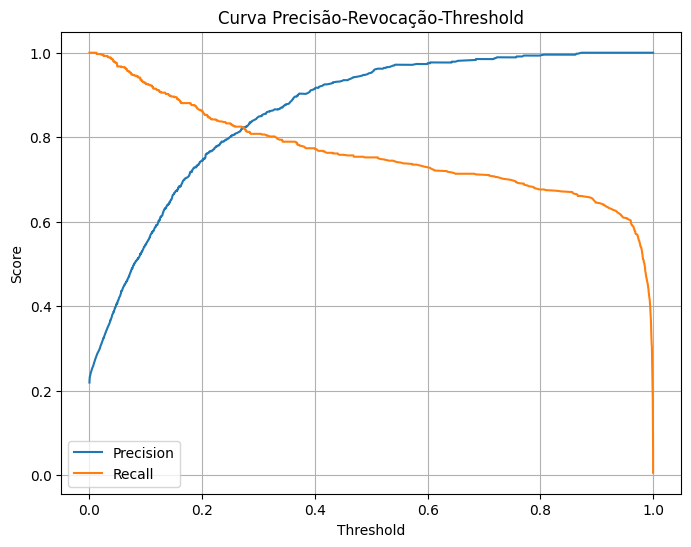

Melhor Limiar (Threshold): 0.51
Maior F1-score: 0.84


In [154]:
xgb_thr, _, y_test_thr, y_pred_thr, _ = treinar_modelo(xgbclassifier, X[features_RFE_xgboost], y, False, False, True)

Utilizamos a métrica F1-Score para encontrar o melhor threshold para o modelo e podemos confirmar que a precisão aumenta razoávelmente mais quando a revocação aumenta.

O modelo ajustado geraria estes resultados:

In [150]:
lucro_bruto(y_test_thr, y_pred_thr)

----------------------------------------------------------------
Evitaríamos o prejuízo de R$ 4993375.00
----------------------------------------------------------------
Os falsos positivos resultariam em um prejuízo de R$ 213075.00
----------------------------------------------------------------
Os falsos negativos resultariam em um prejuízo de R$ 1379500.00
----------------------------------------------------------------
Teríamos um prejuízo total de R$ 1592575.00
----------------------------------------------------------------
Obteríamos o LUCRO LÍQUIDO de R$ 21836850.00
----------------------------------------------------------------
LUCRO BRUTO de R$ 20244275.00


Vamos falar de valores comparando com o ajuste do threshold:
- Quanto reduziriamos do prejuízo?
- Quanto de lucro bruto acima obteriamos?

In [166]:
print(f'Reduziríamos o prejuízo em R$ {abs(1592575.00 - prejuizo_total):.2f}')
print(f'Obteríamos R$ {abs(20244275.00 - lucro_bruto)} de lucro a mais.')

Reduziríamos o prejuízo em R$ 38400.00
Obteríamos R$ 76800.0 de lucro a mais.


Concluindo, confirmamos que seria obtido com um threshold de 0.51:
- O maior **LUCRO BRUTO** de **R$ 20.244.275,00**; e
- O menor **prejuízo total** de **R$ 1.592.575,00**